# Importing libraries and files 

In [1]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geodatasets
import h3
from shapely.geometry import Polygon

ModuleNotFoundError: No module named 'geodatasets'

## Creating the CSV file 

In [4]:
# Getting the list of csv before importing them 
path = 'dvfplus-selected/DVF_PLUS_2025_2_CSV_R999_ED251/1_DONNEES_LIVRAISON'
os.chdir(path)
files = os.listdir()

In [5]:
# Importing all the csv and concatening them
# Can take some times
df = pd.concat((pd.read_csv(file,sep='|') for file in files),ignore_index=True)

/var/folders/h_/8kpmh0nd0qqdmdc_k6x_pfrm0000gn/T/ipykernel_96349/3184738901.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((pd.read_csv(file,sep='|') for file in files),ignore_index=True)


In [2]:
df.to_parquet('transac.parquet')

NameError: name 'df' is not defined

In [2]:
# The columns are not loaded using parquet
df_reduced = pd.read_parquet('transac.parquet',columns=relev_cols)

NameError: name 'relev_cols' is not defined

## Directly dowloading it 

In [ ]:
# Online version 
url = 'https://minio.lab.sspcloud.fr/tomvxz/diffusion/transac.parquet'
df_reduced = pd.read_parquet(url)

Se reporter à cette documentation pour l'explication des variables : https://doc-datafoncier.cerema.fr/doc/dv3f/mutation. La plupart sont inutiles pour le projet.

# Dictionnaire des variables - Jeu de données DV3F (Cerema)



Ce jeu de données est issu des **Demandes de Valeurs Foncières (DVF)** retraitées par le **Cerema**. Il recense les mutations immobilières à titre onéreux (ventes, échanges, adjudications).

## 1. Identifiants et Références
Ces clés permettent l'unicité de la ligne ou la jointure avec d'autres tables (Fichiers Fonciers / Majic).

| Colonne | Description |
| :--- | :--- |
| **`idmutation`** | Identifiant unique de la transaction (généré par le Cerema). |
| `idmutinvar` | Identifiant stable pour joindre avec les Fichiers Fonciers (Majic). |
| `idopendata` | Identifiant d'origine dans le fichier DVF brut (DGFiP). |
| `codservch` | Code du Service de la Publicité Foncière (SPF). |
| `refdoc` | Référence de publication (Volume / Numéro). |

## 2. Date et Nature de la Transaction

| Colonne | Description |
| :--- | :--- |
| **`datemut`** | Date précise de la mutation. |
| `anneemut` | Année de la mutation. |
| `moismut` | Mois de la mutation. |
| `idnatmut` | Code de la nature de la mutation (1 = Vente, etc.). |
| **`libnatmut`** | Libellé de la nature (ex: "Vente", "Vente en l'état futur d'achèvement"). |
| **`vefa`** | Indicateur (Vrai/Faux) : Vente en l'État Futur d'Achèvement (neuf). |
| `nbartcgi` | Nombre d'articles du CGI (régime fiscal). |
| `l_artcgi` | Liste des codes articles du CGI. |
| `nbdispo` | Nombre de dispositions dans l'acte. |

## 3. Localisation Géographique

| Colonne | Description |
| :--- | :--- |
| `coddep` | Code département (ex: 75, 59). |
| `nbcomm` | Nombre de communes concernées. |
| `l_codinsee` | Liste des codes INSEE des communes. |
| `nbsection` / `l_section` | Nombre et liste des sections cadastrales. |
| `nbpar` / `l_idpar` | Nombre et liste des identifiants de parcelles concernées. |
| `nbparmut` / `l_idparmut` | Nombre et liste des parcelles **réellement mutées**. |
| `geompar_x` / `geompar_y` | Coordonnées géographiques (centroïdes). |

## 4. Prix et Foncier (Terrain)

| Colonne | Description |
| :--- | :--- |
| **`valeurfonc`** | **Montant global de la transaction** (Net Vendeur). *Somme pour tous les biens de la mutation.* |
| `sterr` | Surface totale du terrain en m². |
| `l_dcnt` | Liste des contenances (surfaces) cadastrales. |
| `nbsuf` | Nombre de surfaces (lien Fichiers Fonciers). |

## 5. Caractéristiques du Bâti (Général)

| Colonne | Description |
| :--- | :--- |
| `codtypbien` | Code typologie du bien (calculé par le Cerema). |
| **`libtypbien`** | Libellé typologie (ex: "Maison", "Appartement ancien", "Terrain à bâtir"). |
| **`sbati`** | Surface bâtie totale (m²) de tous les locaux. |
| `nblot` | Nombre de lots de copropriété. |
| `nbvolmut` | Nombre de volumes mutés. |
| `nblocmut` | Nombre total de locaux mutés. |
| `l_idlocmut` | Liste des identifiants des locaux. |

## 6. Détail par Type de Local
Répartition des locaux par catégorie et surfaces associées.

| Colonne (Nombre) | Colonne (Surface) | Description |
| :--- | :--- | :--- |
| `nblocmai` | `sbatmai` | Nombre et surface bâtie des **Maisons**. |
| `nblocapt` | `sbatapt` | Nombre et surface bâtie des **Appartements**. |
| `nblocact` | `sbatact` | Nombre et surface bâtie des **Locaux d'activité**. |
| `nblocdep` | - | Nombre de **Dépendances** isolées. |

## 7. Détail des Pièces (Logements)
Détail par nombre de pièces principales (PP).
*Note : `5pp` correspond à "5 pièces et plus".*

| Type | Compteurs (Nombre) | Surfaces (m²) |
| :--- | :--- | :--- |
| **Appartements** | `nbapt1pp` à `nbapt5pp` | `sapt1pp` à `sapt5pp` |
| **Maisons** | `nbmai1pp` à `nbmai5pp` | `smai1pp` à `smai5pp` |

---
> ** Note Importante pour l'analyse :**
> La colonne **`valeurfonc`** représente la valeur totale de la mutation (`idmutation`). Si une ligne contient plusieurs biens (ex: un immeuble avec `nblocapt` = 10), la valeur foncière est le prix global de l'immeuble, et non le prix par appartement.

# Cleaning  

In [ ]:
df['coddep'] = df['coddep'].astype(str)

In [ ]:
relev_cols=['anneemut','datemut','valeurfonc','coddep','sbati','sterr','geompar_x','geompar_y','libtypbien']

In [6]:
#Checking for na values and non-relevant ones (0 and 1€ transactions)
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==1].count()) 
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==0].count())
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc'].isna()].count())

102501
5288
0


In [14]:
# Following previous anaylysis, we clean the data 

# Removing irrelevant transactions based on price
view_price = df_reduced.loc[:,'valeurfonc']
view_geo = df_reduced.loc[:,'geompar_x']
filter = (view_price==0) | (view_price==1)  | (view_price.isna()) | (view_geo.isna())
df_cleaned = df_reduced[~filter].copy()


In [12]:
# We check the other columns 
for col in relev_cols:
    print(df_cleaned[col].isna().sum())

0
0
0
0
0
0
0
0
0


In [13]:
# We check for weird case that could happen else than na values
print(df_cleaned['anneemut'].min(),df_cleaned['anneemut'].max()) #Checking the range of years
print(df_cleaned['datemut'].min(),df_cleaned['datemut'].max()) #Checking concistency with years
print(df_cleaned['valeurfonc'].min(),df_cleaned['valeurfonc'].max()) #Checking range of prices
print(df_cleaned['sbati'].min(),df_cleaned['sbati'].max()) #Checkin range of surfaces
print(df_cleaned['sterr'].min(),df_cleaned['sterr'].max())

2014 2025
2014-01-01 2025-06-30
0.01 14149999600.0
0.0 706238.0
0.0 35055638.0


In [14]:
df_cleaned['coddep'].unique() # Checking coherent dep codes

array(['79', '51', '45', '92', '86', '87', '93', '44', '50', '78', '46',
       '52', '85', '91', '90', '84', '53', '47', '43', '80', '94', '95',
       '81', '56', '42', '54', '40', '83', '82', '69', '41', '55', '32',
       '26', '27', '33', '2A', '19', '25', '31', '30', '24', '18', '2B',
       '34', '8', '9', '35', '21', '37', '23', '22', '36', '13', '7', '6',
       '12', '38', '4', '10', '11', '5', '39', '1', '15', '29', '28',
       '14', '16', '2', '3', '17', '58', '70', '64', '972', '973', '65',
       '71', '59', '73', '971', '72', '66', '62', '76', '89', '974', '88',
       '77', '63', '75', '61', '49', '48', '60', '74'], dtype=object)

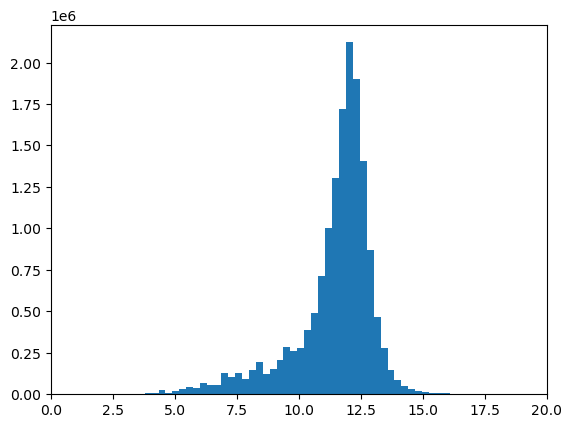

In [5]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['valeurfonc']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.xlim([0,20])
plt.show()

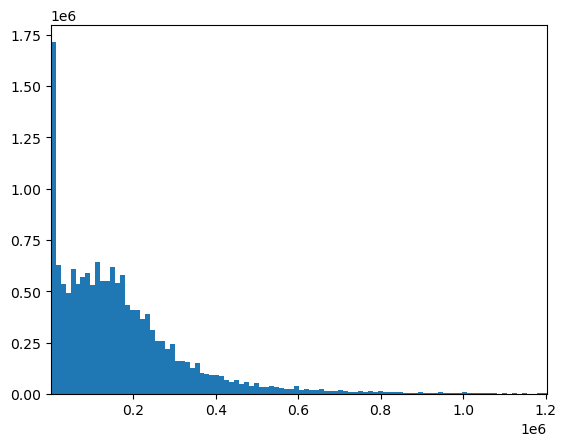

In [6]:
# Creating bins with numpy for faster computations
df_histo = df_cleaned.loc[np.log(df_cleaned['valeurfonc'])<=14]['valeurfonc']
counts, bin_edges = np.histogram(df_histo, bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.margins(x=0)
plt.show()

In [15]:
# Since valeurfonc is highly dependant on the size of the building/house sold, we look at price/m2
# We choose to divide first by the built surface (other approches to come)
df_cleaned.loc[:,'p/m2']=df_cleaned['valeurfonc']/df_cleaned['sbati']

In [18]:
# Voir comment utiliser
df_cleaned['libtypbien'].unique()

array(['UNE MAISON', 'TERRAIN DE TYPE TERRE ET PRE',
       'TERRAIN DE TYPE TAB', 'UN APPARTEMENT',
       'TERRAIN NON BATIS INDETERMINE', 'TERRAIN LANDES ET EAUX',
       'TERRAIN FORESTIER', 'DES MAISONS', 'TERRAIN ARTIFICIALISE MIXTE',
       'BATI - INDETERMINE : Vefa sans descriptif', 'ACTIVITE',
       'TERRAIN VITICOLE', 'DES DEPENDANCES', 'BATI MIXTE - LOGEMENTS',
       'BATI - INDETERMINE : Vente avec volume(s)',
       'BATI MIXTE - LOGEMENT/ACTIVITE', "TERRAIN D'AGREMENT",
       'UNE DEPENDANCE', 'APPARTEMENT INDETERMINE',
       'TERRAIN AGRICOLE MIXTE', 'DEUX APPARTEMENTS', 'TERRAIN VERGER',
       "TERRAIN D'EXTRACTION", 'TERRAIN DE TYPE RESEAU',
       'TERRAIN NATUREL MIXTE', 'MAISON - INDETERMINEE'], dtype=object)

In [16]:
# Geopandas

projections = {
    "Metro":  "EPSG:2154",  # Lambert 93 (France entière hors DOM)
    "971":    "EPSG:5490",  # Guadeloupe (UTM 20N)
    "972":    "EPSG:5490",  # Martinique (UTM 20N)
    "973":    "EPSG:2972",  # Guyane (UTM 22N)
    "974":    "EPSG:2975",  # La Réunion (UTM 40S)
    "976":    "EPSG:4471"   # Mayotte
}

parts = []

#Handling each zones (DOM/TOM have specific zones)
for zone, epsg_code in projections.items():
    if zone == "Metro":
        # Everything that is not a DOM/TOM
        subset = df_cleaned.loc[~df_cleaned['coddep'].str.startswith('97')]
    else:
        # Take specific zone
        subset = df_cleaned.loc[df_cleaned['coddep'] == zone]
    
    if not subset.empty:
        gdf_subset = gpd.GeoDataFrame(
            subset,
            geometry=gpd.points_from_xy(subset['geompar_x'], subset['geompar_y']),
            crs=epsg_code
        )
        
        # Converting to GPS coordinates
        gdf_subset = gdf_subset.to_crs("EPSG:4326")
        
        parts.append(gdf_subset)

gdf_final = pd.concat(parts)



In [ ]:
print(gdf_final.geometry.is_empty.sum()) 

0


In [21]:
gdf_final.sample(100).explore()

In [ ]:

# 1. Configuration
# Note : Résolution 3 est très vaste (échelle régionale). 
# Pour des quartiers, visez plutôt 7, 8 ou 9.
RESOLUTION = 3

# ---------------------------------------------------------
# OPTIMISATION 1 : Calcul des index H3 (Le plus critique)
# ---------------------------------------------------------

# On extrait les colonnes en tableaux NumPy purs (.values)
# C'est beaucoup plus rapide que d'accéder à geometry.x ligne par ligne
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values

# On utilise une compréhension de liste avec zip
# C'est la méthode standard la plus rapide en Python pur
gdf_final['h3_index'] = [
    h3.latlng_to_cell(lat, lon, RESOLUTION) 
    for lat, lon in zip(lats, lons)
]

# 2. Agréger les données
# Cette étape est nativement optimisée en C par Pandas, rien à changer.
df_counts = gdf_final.groupby('h3_index')['valeurfonc'].median().reset_index(name='median')

# ---------------------------------------------------------
# OPTIMISATION 2 : Reconstruction de la géométrie
# ---------------------------------------------------------

def hex_to_poly_optimized(h3_id):
    # cell_to_boundary renvoie ((lat, lon), (lat, lon)...)
    points = h3.cell_to_boundary(h3_id)
    # Inversion (Lat, Lon) -> (Lon, Lat) + Création Polygon
    return Polygon([(lng, lat) for lat, lng in points])

# Ici aussi, on évite .apply() pour utiliser une boucle de liste directe
gdf_h3 = gpd.GeoDataFrame(
    df_counts,
    geometry=[hex_to_poly_optimized(h_id) for h_id in df_counts['h3_index'].values],
    crs="EPSG:4326"
)

# 4. Affichage
m = gdf_h3.explore(
    column="median",
    cmap="inferno",
    style_kwds={"fillOpacity": 0.6, "weight": 0},
    tiles="CartoDB positron"
)
m

NameError: name 'gdf_final' is not defined